# Natural Product Likeness Analysis

Sample molecules from COCONUT and ChEMBL35 datasets and compare their natural product likeness using perplexity.


In [21]:
import sys
import os

sys.path.append(os.path.abspath("../.."))
smiles_gpt_path = os.path.abspath("../../externals/smiles-gpt")
sys.path.append(smiles_gpt_path)
sys.path.append(
    os.path.join(
        os.environ.get("VIRTUAL_ENV", ""),
        "lib",
        "python3.12",
        "site-packages",
        "rdkit",
        "Contrib",
    )
)

In [22]:
MODEL_CHECKPOINT = "../../model/coconut_chiral_deepchem_tokenizer/model.ckpt"
TOKENIZER_NAME = "kohbanye/SmilesTokenizer_PubChem_1M"
USE_HF_TOKENIZER = True

DATASETS = [
    ("../../data/coconut_chiral.smi", "COCONUT"),
    ("../../data/chembl_35_chiral.smi", "ChEMBL35"),
]

N_SAMPLES_PER_DATASET = 10000
RANDOM_SEED = 42
BATCH_SIZE = 32

SIGMOID_K = 0.5  # Sigmoid slope for normalization
SIGMOID_CENTER = 5.0  # Sigmoid center point
MAX_PERPLEXITY_PLOT = 20  # Maximum perplexity for plots

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import random
from rdkit import Chem
from rdkit.Chem import Descriptors
from NP_Score import npscorer

from npgpt import SmilesGptModel, SmilesGptTrainingConfig, get_tokenizer

# Set style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

## Load Model and Tokenizer


In [24]:
# Load model and tokenizer using configuration
config = SmilesGptTrainingConfig()
tokenizer = get_tokenizer(config, TOKENIZER_NAME, USE_HF_TOKENIZER)

model = SmilesGptModel.load_from_checkpoint(
    MODEL_CHECKPOINT,
    config=config,
    tokenizer=tokenizer,
    strict=False,
)

model.eval()
print("Model loaded successfully")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Model loaded successfully


## Score Calculation Functions


In [25]:
fscore = npscorer.readNPModel()


def calculate_np_score(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return npscorer.scoreMol(mol, fscore)
    except Exception as e:
        print(f"Error calculating NP score for '{smiles}': {e}")
        return None


def normalize_np_score(np_score, min_score=-3, max_score=3):
    if np_score is None:
        return None
    # Clip to range and normalize
    clipped = np.clip(np_score, min_score, max_score)
    return (clipped - min_score) / (max_score - min_score)

reading NP model ...
model in


In [26]:
def calculate_perplexity(model, tokenizer, smiles):
    try:
        tokens = tokenizer.encode(smiles, add_special_tokens=True)
        input_ids = torch.tensor([tokens])

        with torch.no_grad():
            outputs = model({"input_ids": input_ids, "labels": input_ids})
            loss = outputs.loss

        perplexity = torch.exp(loss).item()
        return perplexity
    except Exception as e:
        print(f"Error processing SMILES '{smiles}': {e}")
        return None


def evaluate_dataset(model, tokenizer, smiles_list, batch_size=None):
    if batch_size is None:
        batch_size = BATCH_SIZE

    results = []
    errors = 0

    for i in tqdm(range(0, len(smiles_list), batch_size)):
        batch = smiles_list[i : i + batch_size]

        for smiles in batch:
            ppl = calculate_perplexity(model, tokenizer, smiles)
            if ppl is not None:
                results.append({"smiles": smiles, "perplexity": ppl})
            else:
                errors += 1

    print(f"Successfully evaluated: {len(results)}, Errors: {errors}")
    return pd.DataFrame(results)

## Dataset Sampling


In [27]:
def load_and_sample(filepath, n_samples=None, seed=None):
    if n_samples is None:
        n_samples = N_SAMPLES_PER_DATASET
    if seed is None:
        seed = RANDOM_SEED

    with open(filepath, "r") as f:
        all_smiles = []
        for line in f:
            if line.strip():
                # Handle both formats: "SMILES" and "SMILES\tID"
                parts = line.strip().split("\t")
                smiles = parts[0]
                all_smiles.append(smiles)

    random.seed(seed)
    n_samples = min(n_samples, len(all_smiles))
    sampled = random.sample(all_smiles, n_samples)

    print(f"Loaded {len(all_smiles)} molecules, sampled {n_samples}")
    return sampled


dataset_samples = {}
for filepath, dataset_name in DATASETS:
    print(f"\nLoading {dataset_name}...")
    samples = load_and_sample(filepath)
    dataset_samples[dataset_name] = samples

print(f"\nLoaded {len(DATASETS)} datasets successfully")


Loading COCONUT...
Loaded 895557 molecules, sampled 10000

Loading ChEMBL35...
Loaded 2474590 molecules, sampled 10000

Loaded 2 datasets successfully


## Perplexity Evaluation


In [28]:
all_results = []

for dataset_name, samples in dataset_samples.items():
    print(f"Evaluating {dataset_name} samples...")
    results = evaluate_dataset(model, tokenizer, samples)
    results["dataset"] = dataset_name
    all_results.append(results)

all_results = pd.concat(all_results, ignore_index=True)
print(
    f"\nTotal evaluated: {len(all_results)} molecules across {len(DATASETS)} datasets"
)

Evaluating COCONUT samples...


100%|██████████| 313/313 [04:15<00:00,  1.23it/s]


Successfully evaluated: 10000, Errors: 0
Evaluating ChEMBL35 samples...


  1%|▏         | 4/313 [00:01<01:37,  3.16it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 514). Running this sequence through the model will result in indexing errors


Error processing SMILES 'C(=O)(COCCOCCNC(=O)CCCCCCCCCCCCCCCCC(=O)O)NCCCCCCNC(=O)C1NC(=O)CCN2C(=O)C(CC2=O)SC[C@@H](C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@H](C(=O)N2[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)NCC(=O)N[C@H](C(=O)N3[C@H](C(=O)N4CCC[C@H]4C(=O)N4CCC[C@H]4C(=O)N[C@@H](CO)C(=O)N)CCC3)C)CO)CO)CCC2)CCCCN)[C@H](CC)C)CC(C)C)Cc2c3ccccc3[nH]c2)CCC(=O)O)[C@@H](C)CC)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CSC2CC(=O)N(C2=O)CCC(=O)NCCCC1)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H]([C@H](O)C)NC(=O)[C@H](C(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)N)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@@H](NC(=O)CNC(=O)[C@@H](NC(=O)C(C)(NC(=O)[C@H](Cc1c[nH]cn1)N)C)CCC(=O)O)[C@@H](C)O)CC(=O)O)Cc1ccc(O)cc1)CCC(=O)O)C': index out of range in self
Error processing SMILES 'N([C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O

  7%|▋         | 21/313 [00:07<01:33,  3.14it/s]

Error processing SMILES '[Na+].c1(ccc(cc1)C(O)P(=O)([O-])O)OP(=S)(N(/N=C/c1ccc(cc1)OP1(=NP(=NP(=N1)(Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(P(=O)([O-])O)O)Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)C(O)P(=O)([O-])O)(Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(O)P(=O)(O)[O-])Oc1ccc(cc1)C(O)P(=O)([O-])O)C)Oc1ccc(cc1)C(O)P(=O)(O)[O-].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+]': index out of range in self


 55%|█████▍    | 172/313 [01:30<00:45,  3.07it/s]

Error processing SMILES 'n1(c(=O)[nH]c(=O)c(c1)C)[C@H]1C[C@H](O)[C@H](O1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)nc(c(c2)C)N)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)nc(c(c2)C)N)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)nc(c(c2)C)N)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@H](C1)c1cn(nn1)c1ccc(cc1)C)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)nc(c(c2)C)N)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O)O[C@@H]1[C@@H](COP(=O)(O[C@@H]2[C@H](O[C@@H](n3c(=O)[nH]c(=O)c(c3)C)C2)CO)O)O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)O)O)O)O)O)O)O)O)O)O)O)O': index out of range in self


 75%|███████▌  | 236/313 [02:00<00:35,  2.17it/s]

Error processing SMILES 'C(=O)(N1[C@H](C(=O)N[C@H](C(=O)O)CCCCNC(=O)CCCCCCCCCCCCC)CCC1)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@H]1NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](Cc2ccccc2)N)C(C)C)CC(=O)N)CCC(=O)N)Cc2nc[nH]c2)CC(C)C)CSSC[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CN)[C@H](CC)C)C(C)C)CCC(=O)O)CCC(=O)N)CSSC[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC2=O)[C@H](O)C)CO)[C@H](CC)C)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CC(=O)N)C(=O)O)CSSC1)Cc1ccc(cc1)O)CC(=O)N)CCC(=O)O)CC(C)C)CCC(=O)N)Cc1ccc(cc1)O)CC(C)C)CO)CO)Cc1nc[nH]c1)CC(C)C)C(C)C)CCC(=O)O)C)CC(C)C)Cc1ccc(cc1)O)CC(C)C)C(C)C)CCC(=O)O)CCCNC(=N)N)Cc1ccccc1)Cc1ccccc1)Cc1ccc(cc1)O

 81%|████████  | 253/313 [02:06<00:19,  3.05it/s]

Error processing SMILES 'O=C(NC(C)(C)C(=O)N[C@@H](CCC(=O)O)C(=O)NCC(=O)N[C@@H]([C@H](O)C)C(=O)N[C@@H](Cc1ccc(cc1)O)C(=O)N[C@@H]([C@H](O)C)C(=O)N[C@@H](CC(=O)N)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CS)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccc(cc1)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CS)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H](CCCCN)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CO)C(=O)NCC(=O)N[C@@H](C)C(=O)N1[C@@H](CCC1)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N)[C@H](Cc1c[nH]cn1)N': index out of range in self


100%|██████████| 313/313 [02:29<00:00,  2.10it/s]

Successfully evaluated: 9994, Errors: 6

Total evaluated: 19994 molecules across 2 datasets


## RDKit NP Score Calculation


## Statistical Analysis


In [29]:
print("=== Perplexity Statistics ===")
print(all_results.groupby("dataset")["perplexity"].describe())

if len(DATASETS) == 2:
    from scipy import stats

    dataset_names = [name for _, name in DATASETS]
    dataset1_ppl = all_results[all_results["dataset"] == dataset_names[0]][
        "perplexity"
    ].values
    dataset2_ppl = all_results[all_results["dataset"] == dataset_names[1]][
        "perplexity"
    ].values

    # Mann-Whitney U test (non-parametric)
    statistic, p_value = stats.mannwhitneyu(
        dataset1_ppl, dataset2_ppl, alternative="less"
    )
    print(f"\nMann-Whitney U test ({dataset_names[0]} vs {dataset_names[1]}):")
    print(f"  Statistic: {statistic}")
    print(f"  p-value: {p_value:.2e}")
    print(
        f"  {dataset_names[0]} has {'significantly' if p_value < 0.001 else 'not significantly'} lower perplexity than {dataset_names[1]}"
    )
else:
    print(
        f"\nSkipping pairwise statistical test (requires exactly 2 datasets, got {len(DATASETS)})"
    )

=== Perplexity Statistics ===
            count      mean        std       min       25%       50%  \
dataset                                                                
COCONUT   10000.0  1.446053   0.319285  1.054210  1.266975  1.364297   
ChEMBL35   9994.0  8.612860  10.650530  1.494437  4.792236  6.805559   

               75%         max  
dataset                         
COCONUT   1.517491    6.670969  
ChEMBL35  9.979093  681.337585  

Mann-Whitney U test (COCONUT vs ChEMBL35):
  Statistic: 98479.0
  p-value: 0.00e+00
  COCONUT has significantly lower perplexity than ChEMBL35


## Visualization


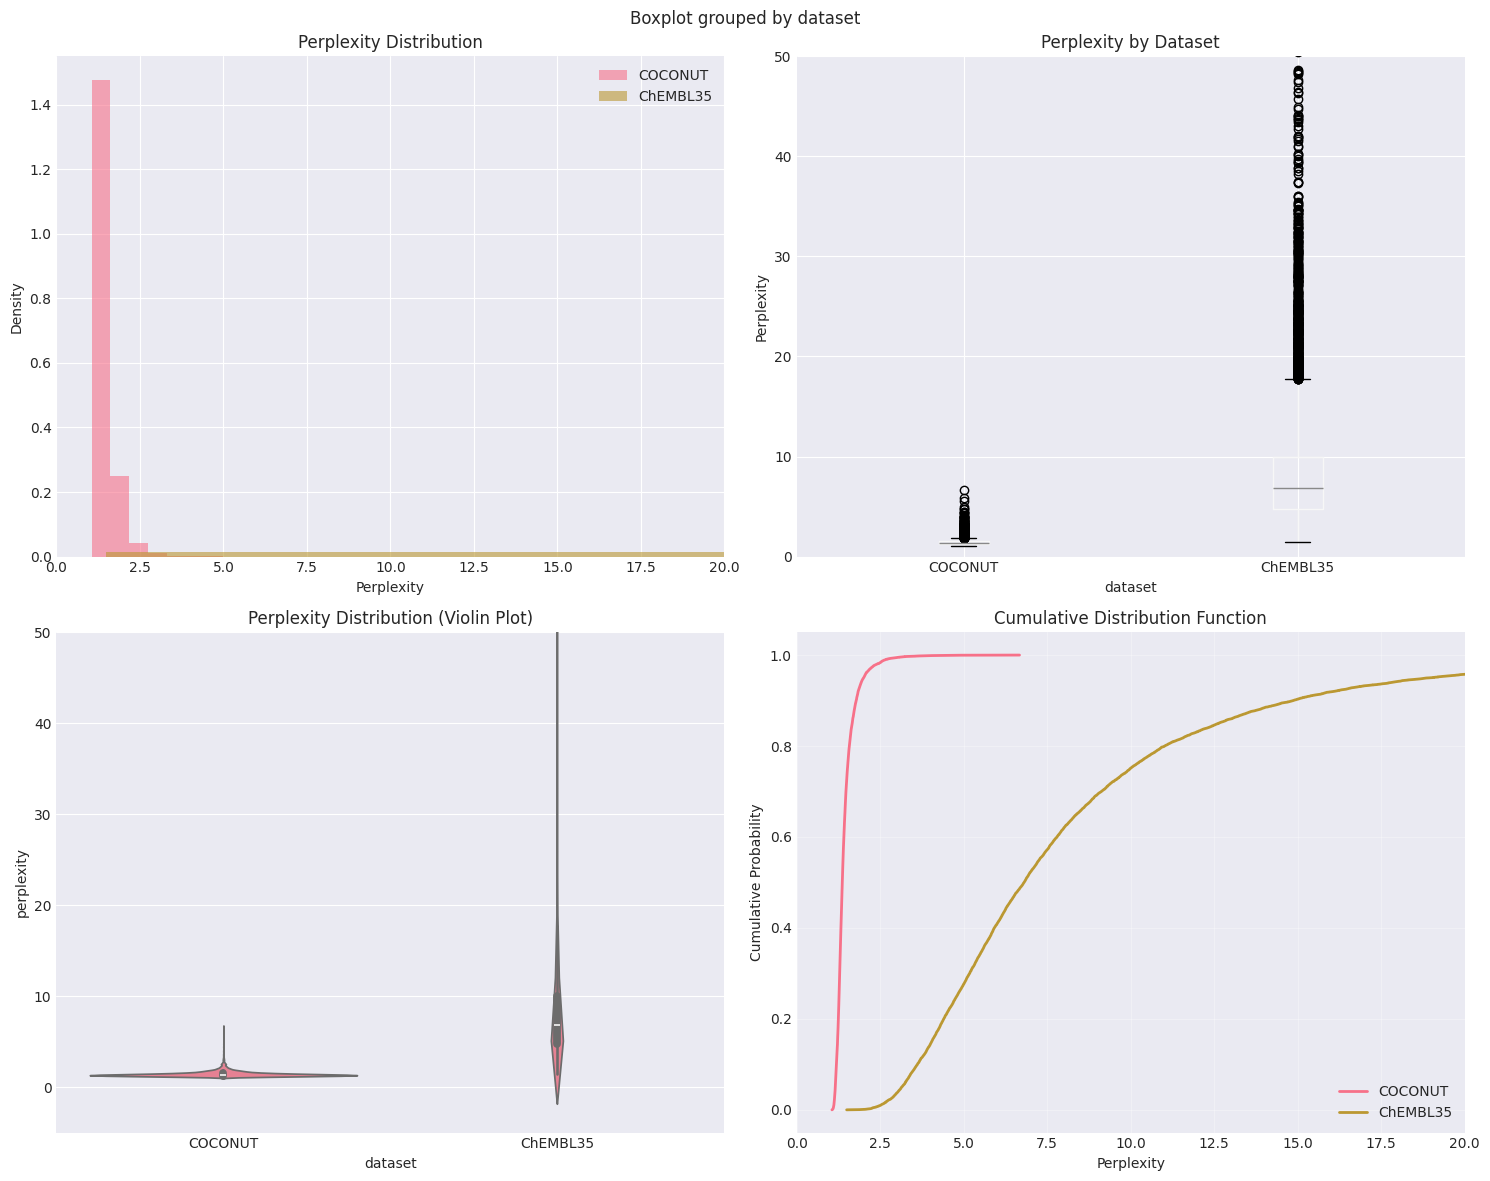

In [30]:
# Create visualizations using configuration
dataset_names = [name for _, name in DATASETS]
n_datasets = len(DATASETS)

if n_datasets == 2:
    # Two-dataset comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    ax = axes[0, 0]
    for dataset in dataset_names:
        data = all_results[all_results["dataset"] == dataset]["perplexity"]
        ax.hist(data, alpha=0.6, label=dataset, density=True)
    ax.set_xlabel("Perplexity")
    ax.set_ylabel("Density")
    ax.set_title("Perplexity Distribution")
    ax.legend()
    ax.set_xlim(0, MAX_PERPLEXITY_PLOT)

    ax = axes[0, 1]
    all_results.boxplot(column="perplexity", by="dataset", ax=ax)
    ax.set_title("Perplexity by Dataset")
    ax.set_ylabel("Perplexity")
    ax.set_ylim(0, MAX_PERPLEXITY_PLOT * 2.5)

    ax = axes[1, 0]
    sns.violinplot(data=all_results, x="dataset", y="perplexity", ax=ax)
    ax.set_title("Perplexity Distribution (Violin Plot)")
    ax.set_ylim(-5, MAX_PERPLEXITY_PLOT * 2.5)

    ax = axes[1, 1]
    for dataset in dataset_names:
        data = all_results[all_results["dataset"] == dataset][
            "perplexity"
        ].sort_values()
        ax.plot(data, np.linspace(0, 1, len(data)), label=dataset, linewidth=2)
    ax.set_xlabel("Perplexity")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Cumulative Distribution Function")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, MAX_PERPLEXITY_PLOT)

else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    ax = axes[0, 0]
    for dataset in dataset_names:
        data = all_results[all_results["dataset"] == dataset]["perplexity"]
        ax.hist(data, alpha=0.6, label=dataset, density=True)
    ax.set_xlabel("Perplexity")
    ax.set_ylabel("Density")
    ax.set_title("Perplexity Distribution")
    ax.legend()
    ax.set_xlim(0, MAX_PERPLEXITY_PLOT)

    ax = axes[0, 1]
    sns.boxplot(data=all_results, x="dataset", y="perplexity", ax=ax)
    ax.set_title("Perplexity by Dataset")
    ax.set_ylabel("Perplexity")
    ax.set_ylim(0, MAX_PERPLEXITY_PLOT * 2)
    ax.tick_params(axis="x", rotation=45)

    ax = axes[1, 0]
    sns.violinplot(data=all_results, x="dataset", y="perplexity", ax=ax)
    ax.set_title("Perplexity Distribution (Violin Plot)")
    ax.set_ylim(0, MAX_PERPLEXITY_PLOT * 2)
    ax.tick_params(axis="x", rotation=45)

    ax = axes[1, 1]
    means = all_results.groupby("dataset")["perplexity"].mean()
    stds = all_results.groupby("dataset")["perplexity"].std()
    ax.bar(means.index, means.values, yerr=stds.values, capsize=5, alpha=0.7)
    ax.set_ylabel("Mean Perplexity")
    ax.set_title("Average Perplexity by Dataset")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## Perplexity Score Normalization (0-1 Range)


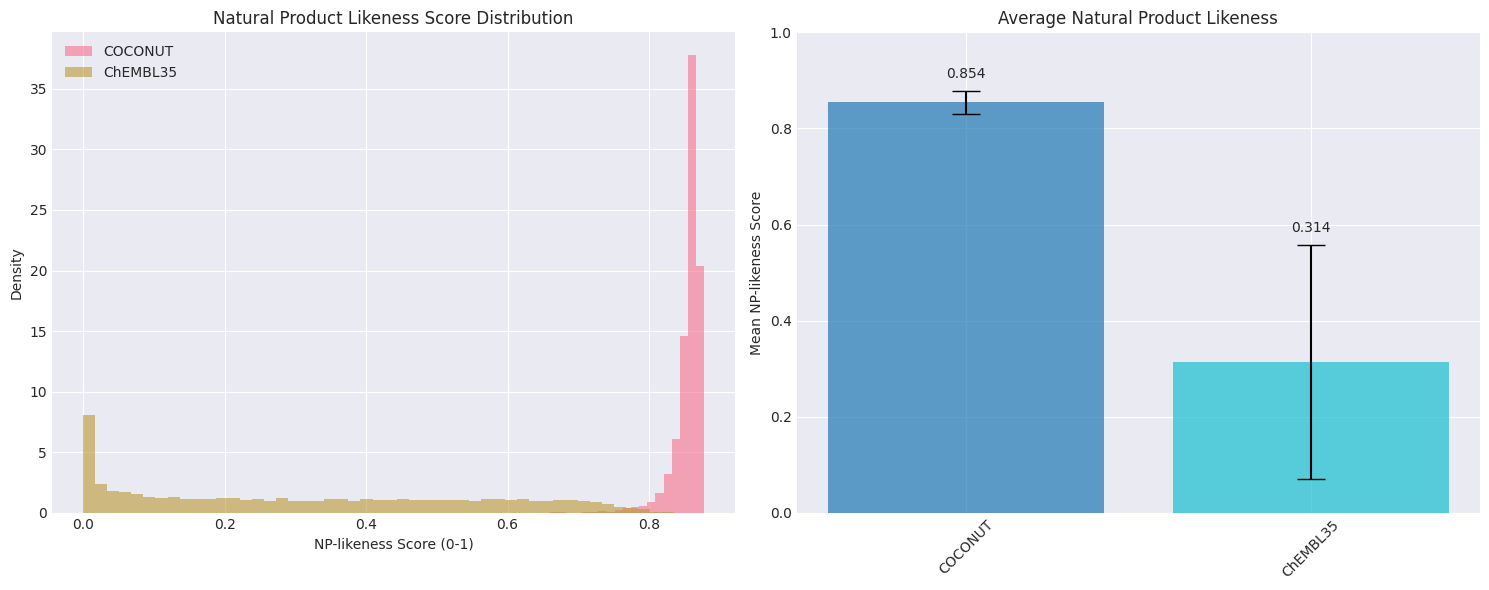


=== NP-likeness Score Summary ===
            count      mean       std            min       25%       50%  \
dataset                                                                    
COCONUT   10000.0  0.854184  0.024344   3.024867e-01  0.850846  0.860308   
ChEMBL35   9994.0  0.314031  0.243535  1.365084e-147  0.076594  0.288480   

               75%       max  
dataset                       
COCONUT   0.866054  0.877922  
ChEMBL35  0.525947  0.852303  


In [31]:
def sigmoid_transform(perplexity, k=None, center=None):
    """Sigmoid transformation to 0-1 range"""
    if k is None:
        k = SIGMOID_K
    if center is None:
        center = SIGMOID_CENTER
    return 1 / (1 + np.exp(k * (perplexity - center)))


# Apply normalization
all_results["np_score"] = all_results["perplexity"].apply(sigmoid_transform)

# Visualize normalized scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Normalized score distribution
for dataset in dataset_names:
    data = all_results[all_results["dataset"] == dataset]["np_score"]
    ax1.hist(data, bins=50, alpha=0.6, label=dataset, density=True)
ax1.set_xlabel("NP-likeness Score (0-1)")
ax1.set_ylabel("Density")
ax1.set_title("Natural Product Likeness Score Distribution")
ax1.legend()

# Mean scores with error bars
mean_scores = all_results.groupby("dataset")["np_score"].agg(["mean", "std"])
colors = plt.cm.tab10(np.linspace(0, 1, len(dataset_names)))
bars = ax2.bar(
    mean_scores.index,
    mean_scores["mean"],
    yerr=mean_scores["std"],
    capsize=10,
    alpha=0.7,
    color=colors,
)
ax2.set_ylabel("Mean NP-likeness Score")
ax2.set_title("Average Natural Product Likeness")
ax2.set_ylim(0, 1)
ax2.tick_params(axis="x", rotation=45)

# Add value labels
for i, (idx, row) in enumerate(mean_scores.iterrows()):
    ax2.text(
        i,
        row["mean"] + row["std"] + 0.02,
        f"{row['mean']:.3f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

# Print summary
print("\n=== NP-likeness Score Summary ===")
print(all_results.groupby("dataset")["np_score"].describe())

## Representative Molecule Examples


In [32]:
for dataset_name in dataset_names:
    dataset_results = all_results[all_results["dataset"] == dataset_name]

    print(f"\n=== {dataset_name} Examples ===")
    print(f"Most Natural Product-like (Lowest Perplexity):")
    top = dataset_results.nsmallest(3, "perplexity")
    for _, row in top.iterrows():
        print(f"  {row['smiles'][:60]}... | Perplexity: {row['perplexity']:.2f}")

    print(f"Least Natural Product-like (Highest Perplexity):")
    bottom = dataset_results.nlargest(3, "perplexity")
    for _, row in bottom.iterrows():
        print(f"  {row['smiles'][:60]}... | Perplexity: {row['perplexity']:.2f}")


=== COCONUT Examples ===
Most Natural Product-like (Lowest Perplexity):
  CCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@H]1[C@@H]([C@H]([C@@H]([C... | Perplexity: 1.05
  CCCCCCCCCCCCCCC[C@H]([C@H](CO[C@H]1[C@@H]([C@H]([C@@H]([C@@H... | Perplexity: 1.06
  O=C(O)C1(OC(CO)C(O)C2OC(OC3C(O)C(OC(CO)C3OC3OC(CO)C(O)C(OC4O... | Perplexity: 1.06
Least Natural Product-like (Highest Perplexity):
  ICC(O)CO... | Perplexity: 6.67
  Ic1ccncc1N... | Perplexity: 5.88
  [O-][I+](O)(O)(O)(O)O... | Perplexity: 5.52

=== ChEMBL35 Examples ===
Most Natural Product-like (Lowest Perplexity):
  Cc1cccc2c1nc1COC[C@H](CNC3CCCCC3)n21... | Perplexity: 1.49
  CC(C)C[C@@H](C(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCCN)N... | Perplexity: 1.53
  O=C(N)C(NN=C(c1ccccc1)c1ccccc1)c1ccccc1... | Perplexity: 1.74
Least Natural Product-like (Highest Perplexity):
  Cl.N1(CCNCCCNCCNCCC1)Cc1ccc(CN2CCNCCCNCCNCCC2)cc1.[Zn+2].[Zn... | Perplexity: 681.34
  Cc1nc(COC[C@@H]2CC[C@H]3NCC[C@H]3O2)cs1.Cl.Cl... | Perplexity: 458.19
  [C-]#[O+]... | 

In [33]:
# Calculate RDKit NP scores for all molecules
print("Calculating RDKit NP scores...")
all_results["rdkit_np_score"] = all_results["smiles"].apply(calculate_np_score)
all_results["rdkit_np_score_normalized"] = all_results["rdkit_np_score"].apply(
    normalize_np_score
)

# Remove rows where NP score calculation failed
valid_results = all_results.dropna(subset=["rdkit_np_score"])
print(f"Successfully calculated NP scores for {len(valid_results)} molecules")

Calculating RDKit NP scores...


[14:28:55] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:28:56] Explicit valence for atom # 19 N, 3, is greater than permitted
[14:28:56] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:28:57] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:28:57] Explicit valence for atom # 18 N, 4, is greater than permitted


Successfully calculated NP scores for 19989 molecules


## Comparison of Scoring Methods


/tmp/38295.1.interactive/ipykernel_1083801/599121346.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(plot_data, labels=labels)
/tmp/38295.1.interactive/ipykernel_1083801/599121346.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_results["gpt_high_np"] = valid_results["np_score"] > 0.5
/tmp/38295.1.interactive/ipykernel_1083801/599121346.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

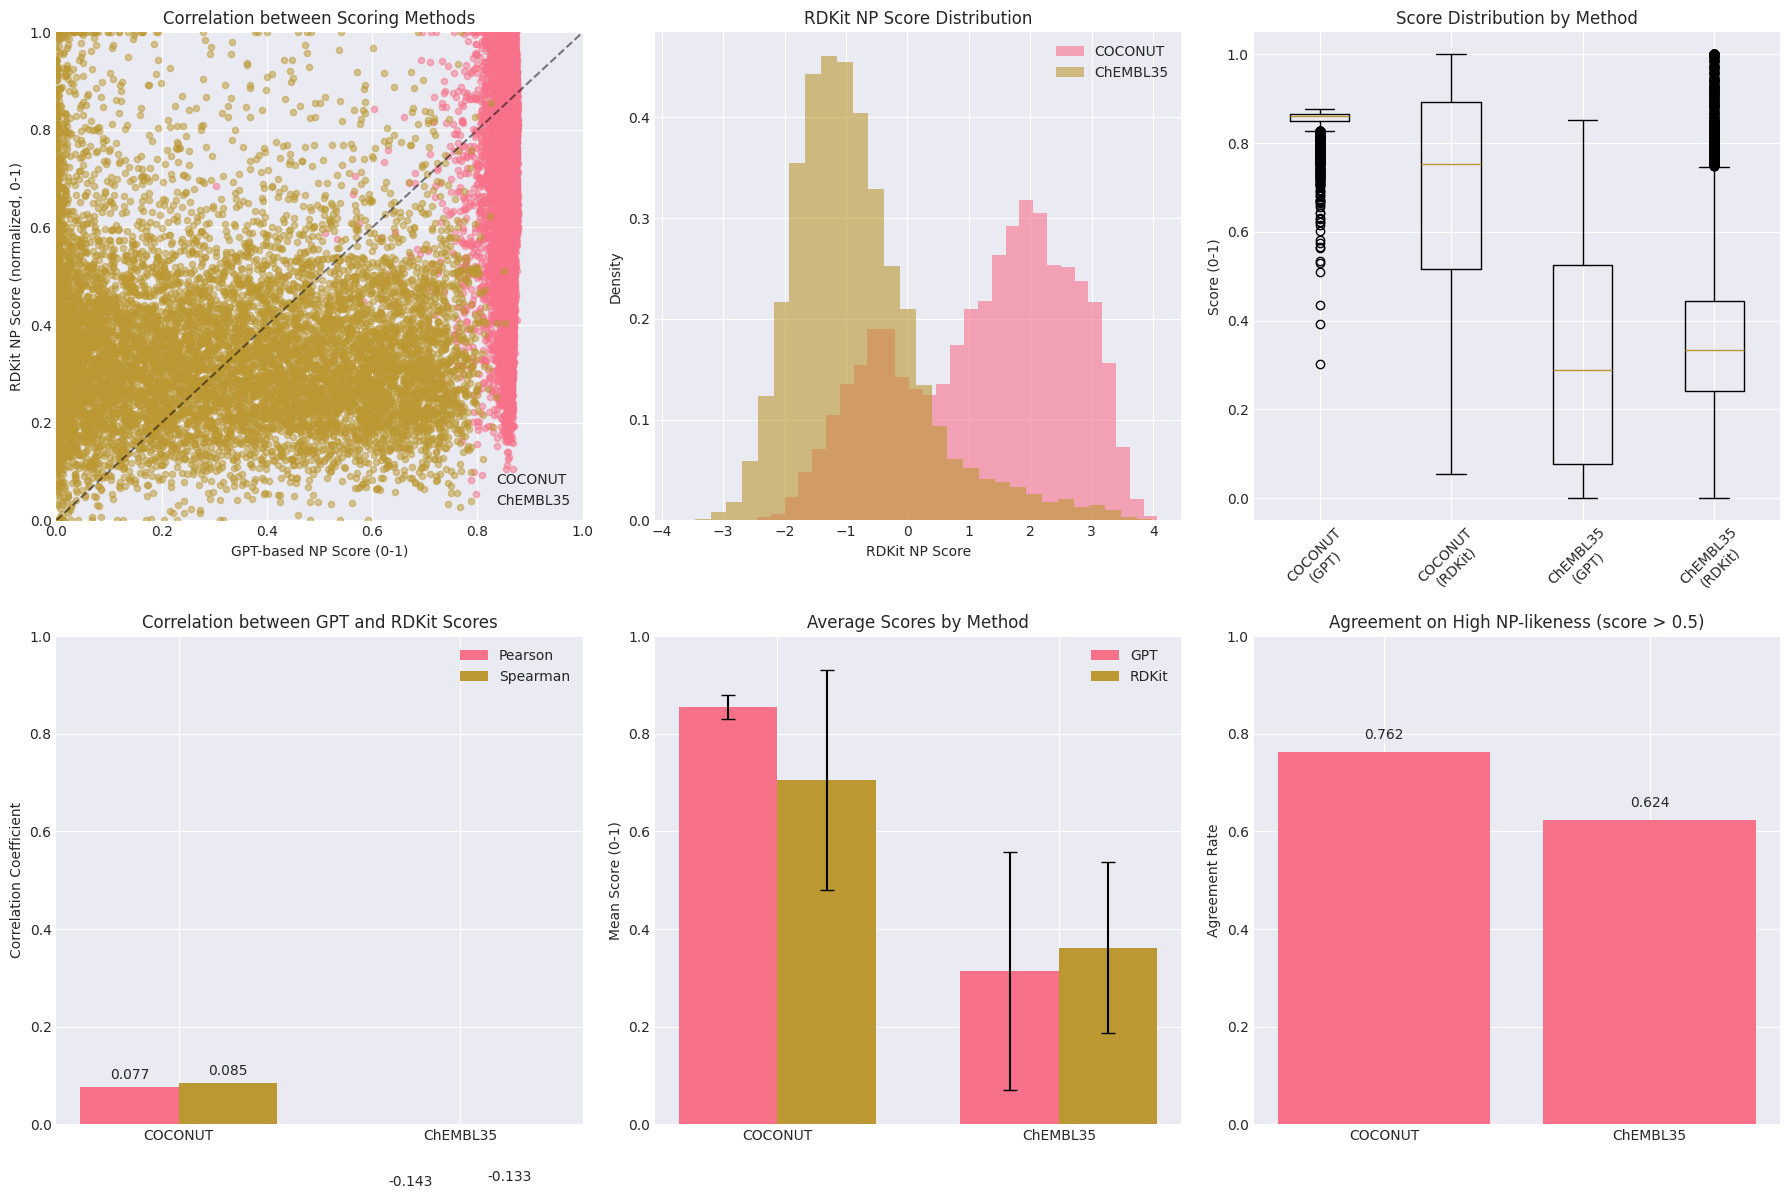


=== Scoring Method Comparison ===

Correlations:
    Dataset  Pearson r  Spearman r
0   COCONUT   0.077054    0.085172
1  ChEMBL35  -0.142834   -0.132896

Mean Scores:
    Dataset  GPT Score  RDKit Score   GPT Std  RDKit Std
0   COCONUT   0.854190     0.705282  0.024341   0.225949
1  ChEMBL35   0.314031     0.361741  0.243535   0.175881

Agreement on High NP-likeness:
    Dataset  Agreement
0   COCONUT   0.762381
1  ChEMBL35   0.623674


In [34]:
# Compare scoring methods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Scatter plot comparing scores
ax = axes[0, 0]
for dataset in dataset_names:
    data = valid_results[valid_results["dataset"] == dataset]
    ax.scatter(
        data["np_score"],
        data["rdkit_np_score_normalized"],
        alpha=0.5,
        label=dataset,
        s=20,
    )
ax.set_xlabel("GPT-based NP Score (0-1)")
ax.set_ylabel("RDKit NP Score (normalized, 0-1)")
ax.set_title("Correlation between Scoring Methods")
ax.legend()
ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="y=x")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# 2. Distribution comparison
ax = axes[0, 1]
for dataset in dataset_names:
    data = valid_results[valid_results["dataset"] == dataset]
    ax.hist(data["rdkit_np_score"], alpha=0.6, label=dataset, density=True, bins=30)
ax.set_xlabel("RDKit NP Score")
ax.set_ylabel("Density")
ax.set_title("RDKit NP Score Distribution")
ax.legend()

# 3. Box plot comparison
ax = axes[0, 2]
plot_data = []
labels = []
for dataset in dataset_names:
    data = valid_results[valid_results["dataset"] == dataset]
    plot_data.extend([data["np_score"], data["rdkit_np_score_normalized"]])
    labels.extend([f"{dataset}\n(GPT)", f"{dataset}\n(RDKit)"])
ax.boxplot(plot_data, labels=labels)
ax.set_ylabel("Score (0-1)")
ax.set_title("Score Distribution by Method")
ax.tick_params(axis="x", rotation=45)

# 4. Correlation analysis
from scipy.stats import pearsonr, spearmanr

ax = axes[1, 0]
correlations = []
for dataset in dataset_names:
    data = valid_results[valid_results["dataset"] == dataset]
    pearson_r, _ = pearsonr(data["np_score"], data["rdkit_np_score_normalized"])
    spearman_r, _ = spearmanr(data["np_score"], data["rdkit_np_score_normalized"])
    correlations.append((dataset, pearson_r, spearman_r))

corr_df = pd.DataFrame(correlations, columns=["Dataset", "Pearson r", "Spearman r"])
x = np.arange(len(dataset_names))
width = 0.35

bars1 = ax.bar(x - width / 2, corr_df["Pearson r"], width, label="Pearson")
bars2 = ax.bar(x + width / 2, corr_df["Spearman r"], width, label="Spearman")

ax.set_ylabel("Correlation Coefficient")
ax.set_title("Correlation between GPT and RDKit Scores")
ax.set_xticks(x)
ax.set_xticklabels(corr_df["Dataset"])
ax.legend()
ax.set_ylim(0, 1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom",
        )

# 5. Mean score comparison
ax = axes[1, 1]
mean_comparison = []
for dataset in dataset_names:
    data = valid_results[valid_results["dataset"] == dataset]
    mean_comparison.append(
        {
            "Dataset": dataset,
            "GPT Score": data["np_score"].mean(),
            "RDKit Score": data["rdkit_np_score_normalized"].mean(),
            "GPT Std": data["np_score"].std(),
            "RDKit Std": data["rdkit_np_score_normalized"].std(),
        }
    )

comp_df = pd.DataFrame(mean_comparison)
x = np.arange(len(dataset_names))

bars1 = ax.bar(
    x - width / 2,
    comp_df["GPT Score"],
    width,
    yerr=comp_df["GPT Std"],
    label="GPT",
    capsize=5,
)
bars2 = ax.bar(
    x + width / 2,
    comp_df["RDKit Score"],
    width,
    yerr=comp_df["RDKit Std"],
    label="RDKit",
    capsize=5,
)

ax.set_ylabel("Mean Score (0-1)")
ax.set_title("Average Scores by Method")
ax.set_xticks(x)
ax.set_xticklabels(comp_df["Dataset"])
ax.legend()
ax.set_ylim(0, 1)

# 6. Agreement analysis
ax = axes[1, 2]
# Define high NP-likeness as score > 0.5
valid_results["gpt_high_np"] = valid_results["np_score"] > 0.5
valid_results["rdkit_high_np"] = valid_results["rdkit_np_score_normalized"] > 0.5

agreement_data = []
for dataset in dataset_names:
    data = valid_results[valid_results["dataset"] == dataset]
    agreement = (data["gpt_high_np"] == data["rdkit_high_np"]).sum() / len(data)
    agreement_data.append((dataset, agreement))

agree_df = pd.DataFrame(agreement_data, columns=["Dataset", "Agreement"])
ax.bar(agree_df["Dataset"], agree_df["Agreement"])
ax.set_ylabel("Agreement Rate")
ax.set_title("Agreement on High NP-likeness (score > 0.5)")
ax.set_ylim(0, 1)

# Add value labels
for i, v in enumerate(agree_df["Agreement"]):
    ax.text(i, v + 0.02, f"{v:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n=== Scoring Method Comparison ===")
print("\nCorrelations:")
print(corr_df)
print("\nMean Scores:")
print(comp_df)
print("\nAgreement on High NP-likeness:")
print(agree_df)

## Examples of Score Differences


In [36]:
# Find molecules where scores differ significantly
valid_results["score_diff"] = abs(
    valid_results["np_score"] - valid_results["rdkit_np_score_normalized"]
)

for dataset_name in dataset_names:
    dataset_results = valid_results[valid_results["dataset"] == dataset_name]

    print(f"\n=== {dataset_name}: Large Score Differences ===")

    # GPT high, RDKit low
    gpt_high_rdkit_low = dataset_results[
        (dataset_results["np_score"] > 0.7)
        & (dataset_results["rdkit_np_score_normalized"] < 0.3)
    ].nlargest(3, "score_diff")

    if len(gpt_high_rdkit_low) > 0:
        print("\nGPT Score High, RDKit Score Low:")
        for _, row in gpt_high_rdkit_low.iterrows():
            print(f"  SMILES: {row['smiles'][:60]}...")
            print(
                f"    GPT Score: {row['np_score']:.3f}, RDKit Score: {row['rdkit_np_score_normalized']:.3f}"
            )
            print(
                f"    Perplexity: {row['perplexity']:.2f}, RDKit NP: {row['rdkit_np_score']:.2f}"
            )

    # RDKit high, GPT low
    rdkit_high_gpt_low = dataset_results[
        (dataset_results["rdkit_np_score_normalized"] > 0.7)
        & (dataset_results["np_score"] < 0.3)
    ].nlargest(3, "score_diff")

    if len(rdkit_high_gpt_low) > 0:
        print("\nRDKit Score High, GPT Score Low:")
        for _, row in rdkit_high_gpt_low.iterrows():
            print(f"  SMILES: {row['smiles'][:60]}...")
            print(
                f"    GPT Score: {row['np_score']:.3f}, RDKit Score: {row['rdkit_np_score_normalized']:.3f}"
            )
            print(
                f"    Perplexity: {row['perplexity']:.2f}, RDKit NP: {row['rdkit_np_score']:.2f}"
            )

# Overall statistics
print("\n=== Score Difference Statistics ===")
print(valid_results.groupby("dataset")["score_diff"].describe())


=== COCONUT: Large Score Differences ===

GPT Score High, RDKit Score Low:
  SMILES: c1cc(cc(c1)C#N)NC(=O)N[C@H]1CO[C@@H]2[C@H](CO[C@H]12)n1c(nnn...
    GPT Score: 0.867, RDKit Score: 0.106
    Perplexity: 1.25, RDKit NP: -2.37
  SMILES: [O-][NH+](O)c1cccc(C=NNc2nn3nnnc3cc2)c1...
    GPT Score: 0.854, RDKit Score: 0.105
    Perplexity: 1.46, RDKit NP: -2.37
  SMILES: O=Cc1c(Cl)nc2sccn12...
    GPT Score: 0.798, RDKit Score: 0.054
    Perplexity: 2.25, RDKit NP: -2.67

=== ChEMBL35: Large Score Differences ===

GPT Score High, RDKit Score Low:
  SMILES: Clc1cccc(OCC(=O)Nc2nccs2)c1...
    GPT Score: 0.768, RDKit Score: 0.027
    Perplexity: 2.61, RDKit NP: -2.84
  SMILES: O=C(Nc1c(ccc(c1)C)C)CCn1nc(cc1C)C...
    GPT Score: 0.745, RDKit Score: 0.033
    Perplexity: 2.86, RDKit NP: -2.80
  SMILES: Clc1ccc(cc1)NC(=O)c1c(scc1)NC(=O)c1noc(c1)C...
    GPT Score: 0.761, RDKit Score: 0.056
    Perplexity: 2.69, RDKit NP: -2.66

RDKit Score High, GPT Score Low:
  SMILES: O1C([C@@H]([C@H]2[C@@]34

/tmp/38295.1.interactive/ipykernel_1083801/1719122217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_results["score_diff"] = abs(


## Randomized SMILES Analysis

To test if the low perplexity is due to memorizing specific atom orderings from the training data, let's evaluate the same molecules with randomized SMILES representations.

In [39]:
def randomize_smiles(smiles, n_attempts=10):
    """Generate a randomized SMILES string for the same molecule"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Try to generate different SMILES representations
        for _ in range(n_attempts):
            # Randomize atom order
            atom_order = list(range(mol.GetNumAtoms()))
            random.shuffle(atom_order)
            mol_shuffled = Chem.RenumberAtoms(mol, atom_order)
            random_smiles = Chem.MolToSmiles(mol_shuffled, canonical=False)

            # Return if we got a different representation
            if random_smiles != smiles:
                return random_smiles

        # If we couldn't get a different representation, return the canonical one
        return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None


# Sample a subset for randomized analysis (this is computationally expensive)
print(
    f"Sampling {N_SAMPLES_PER_DATASET} molecules from each dataset for randomized SMILES analysis..."
)

randomized_results = []

for dataset_name in dataset_names:
    print(f"\nProcessing {dataset_name}...")

    # Get a sample of results
    dataset_results = all_results[all_results["dataset"] == dataset_name]
    sample = dataset_results.sample(
        n=min(N_SAMPLES_PER_DATASET, len(dataset_results)), random_state=RANDOM_SEED
    )

    for idx, row in tqdm(sample.iterrows(), total=len(sample)):
        original_smiles = row["smiles"]
        original_ppl = row["perplexity"]

        # Generate randomized SMILES
        random_smiles = randomize_smiles(original_smiles)

        if random_smiles is not None and random_smiles != original_smiles:
            # Calculate perplexity for randomized SMILES
            random_ppl = calculate_perplexity(model, tokenizer, random_smiles)

            if random_ppl is not None:
                randomized_results.append(
                    {
                        "dataset": dataset_name,
                        "original_smiles": original_smiles,
                        "randomized_smiles": random_smiles,
                        "original_perplexity": original_ppl,
                        "randomized_perplexity": random_ppl,
                        "perplexity_ratio": random_ppl / original_ppl
                        if original_ppl > 0
                        else np.inf,
                    }
                )

randomized_df = pd.DataFrame(randomized_results)
print(f"\nSuccessfully analyzed {len(randomized_df)} randomized molecules")

Sampling 10000 molecules from each dataset for randomized SMILES analysis...

Processing COCONUT...


100%|██████████| 10000/10000 [02:15<00:00, 73.86it/s]



Processing ChEMBL35...


100%|██████████| 9994/9994 [02:05<00:00, 79.74it/s]


Successfully analyzed 19989 randomized molecules


### Randomized SMILES Results

=== Randomized SMILES Analysis ===
         original_perplexity                                           \
                       count      mean        std       min       25%   
dataset                                                                 
COCONUT               9995.0  1.445962   0.319213  1.054210  1.266966   
ChEMBL35              9994.0  8.612860  10.650530  1.494437  4.792236   

                                         randomized_perplexity             \
               50%       75%         max                 count       mean   
dataset                                                                     
COCONUT   1.364290  1.517460    6.670969                9995.0  13.199815   
ChEMBL35  6.805559  9.979093  681.337585                9994.0  15.274910   

          ...                        perplexity_ratio                      \
          ...        75%         max            count      mean       std   
dataset   ...                                              

/tmp/38295.1.interactive/ipykernel_1083801/3150024704.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(plot_data, labels=labels)


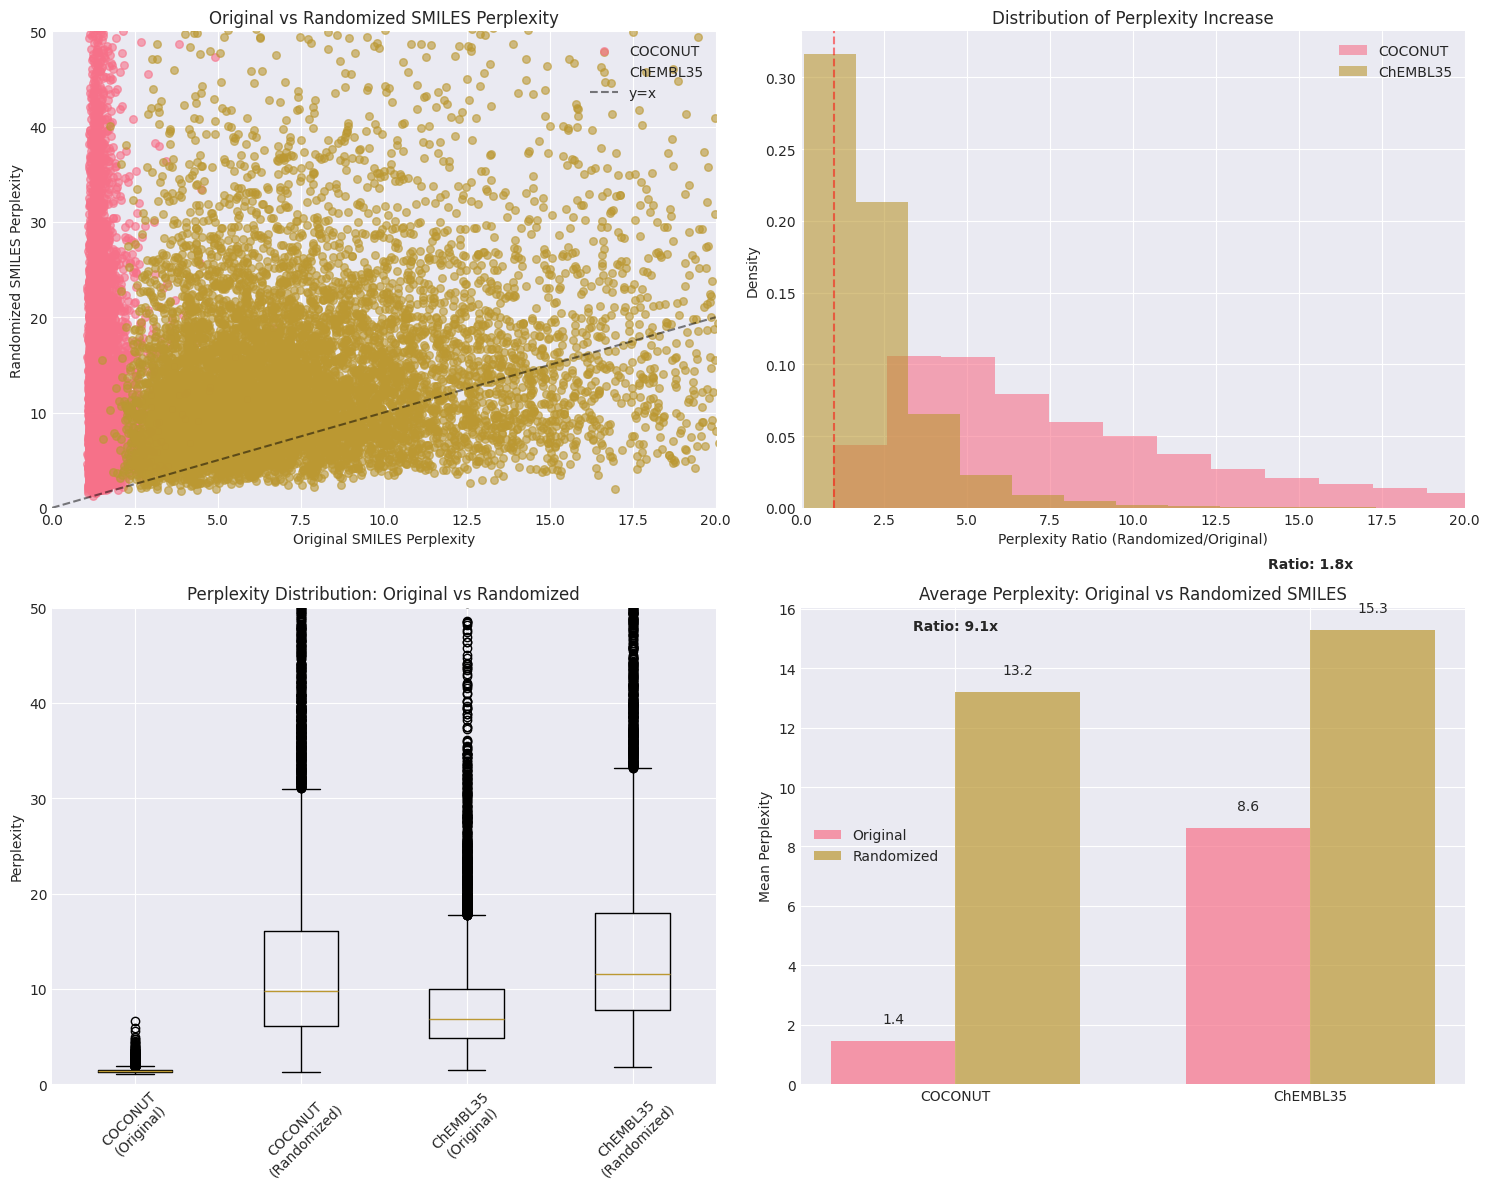


=== Summary Statistics ===

COCONUT:
  Mean original perplexity: 1.45
  Mean randomized perplexity: 13.20
  Mean perplexity ratio: 9.42x
  Median perplexity ratio: 6.91x
  % with higher perplexity after randomization: 100.0%

ChEMBL35:
  Mean original perplexity: 8.61
  Mean randomized perplexity: 15.27
  Mean perplexity ratio: 2.20x
  Median perplexity ratio: 1.67x
  % with higher perplexity after randomization: 78.3%

=== Statistical Tests ===

COCONUT - Paired t-test (Original vs Randomized):
  t-statistic: -99.858
  p-value: 0.00e+00

ChEMBL35 - Paired t-test (Original vs Randomized):
  t-statistic: -45.146
  p-value: 0.00e+00


In [41]:
# Analyze the results
if len(randomized_df) > 0:
    print("=== Randomized SMILES Analysis ===")
    print(
        randomized_df.groupby("dataset")[
            ["original_perplexity", "randomized_perplexity", "perplexity_ratio"]
        ].describe()
    )

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Scatter plot: Original vs Randomized perplexity
    ax = axes[0, 0]
    for dataset in dataset_names:
        data = randomized_df[randomized_df["dataset"] == dataset]
        ax.scatter(
            data["original_perplexity"],
            data["randomized_perplexity"],
            alpha=0.6,
            label=dataset,
            s=30,
        )
    ax.set_xlabel("Original SMILES Perplexity")
    ax.set_ylabel("Randomized SMILES Perplexity")
    ax.set_title("Original vs Randomized SMILES Perplexity")
    ax.plot([0, 20], [0, 20], "k--", alpha=0.5, label="y=x")
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 50)
    ax.legend()

    # 2. Distribution of perplexity ratios
    ax = axes[0, 1]
    for dataset in dataset_names:
        data = randomized_df[randomized_df["dataset"] == dataset]
        # Filter out extreme outliers for visualization
        ratio_data = data["perplexity_ratio"][data["perplexity_ratio"] < 50]
        ax.hist(ratio_data, bins=30, alpha=0.6, label=dataset, density=True)
    ax.set_xlabel("Perplexity Ratio (Randomized/Original)")
    ax.set_ylabel("Density")
    ax.set_title("Distribution of Perplexity Increase")
    ax.set_xlim(0, 20)
    ax.legend()
    ax.axvline(x=1, color="red", linestyle="--", alpha=0.5, label="No change")

    # 3. Box plot comparison
    ax = axes[1, 0]
    plot_data = []
    labels = []
    for dataset in dataset_names:
        data = randomized_df[randomized_df["dataset"] == dataset]
        plot_data.extend([data["original_perplexity"], data["randomized_perplexity"]])
        labels.extend([f"{dataset}\n(Original)", f"{dataset}\n(Randomized)"])
    ax.boxplot(plot_data, labels=labels)
    ax.set_ylabel("Perplexity")
    ax.set_title("Perplexity Distribution: Original vs Randomized")
    ax.set_ylim(0, 50)
    ax.tick_params(axis="x", rotation=45)

    # 4. Mean perplexity comparison
    ax = axes[1, 1]
    mean_comparison = []
    for dataset in dataset_names:
        data = randomized_df[randomized_df["dataset"] == dataset]
        mean_comparison.append(
            {
                "Dataset": dataset,
                "Original": data["original_perplexity"].mean(),
                "Randomized": data["randomized_perplexity"].mean(),
                "Ratio": data["randomized_perplexity"].mean()
                / data["original_perplexity"].mean(),
            }
        )

    comp_df = pd.DataFrame(mean_comparison)
    x = np.arange(len(dataset_names))
    width = 0.35

    bars1 = ax.bar(
        x - width / 2, comp_df["Original"], width, label="Original", alpha=0.7
    )
    bars2 = ax.bar(
        x + width / 2, comp_df["Randomized"], width, label="Randomized", alpha=0.7
    )

    ax.set_ylabel("Mean Perplexity")
    ax.set_title("Average Perplexity: Original vs Randomized SMILES")
    ax.set_xticks(x)
    ax.set_xticklabels(comp_df["Dataset"])
    ax.legend()

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.5,
                f"{height:.1f}",
                ha="center",
                va="bottom",
            )

    # Add ratio labels
    for i, ratio in enumerate(comp_df["Ratio"]):
        ax.text(
            i,
            max(comp_df["Original"][i], comp_df["Randomized"][i]) + 2,
            f"Ratio: {ratio:.1f}x",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n=== Summary Statistics ===")
    for dataset in dataset_names:
        data = randomized_df[randomized_df["dataset"] == dataset]
        print(f"\n{dataset}:")
        print(f"  Mean original perplexity: {data['original_perplexity'].mean():.2f}")
        print(
            f"  Mean randomized perplexity: {data['randomized_perplexity'].mean():.2f}"
        )
        print(f"  Mean perplexity ratio: {data['perplexity_ratio'].mean():.2f}x")
        print(f"  Median perplexity ratio: {data['perplexity_ratio'].median():.2f}x")
        print(
            f"  % with higher perplexity after randomization: {(data['perplexity_ratio'] > 1).sum() / len(data) * 100:.1f}%"
        )

    # Statistical test
    from scipy import stats

    print("\n=== Statistical Tests ===")
    for dataset in dataset_names:
        data = randomized_df[randomized_df["dataset"] == dataset]
        # Paired t-test
        statistic, p_value = stats.ttest_rel(
            data["original_perplexity"], data["randomized_perplexity"]
        )
        print(f"\n{dataset} - Paired t-test (Original vs Randomized):")
        print(f"  t-statistic: {statistic:.3f}")
        print(f"  p-value: {p_value:.2e}")

else:
    print("No randomized results to analyze.")